In [1]:
import numpy as np
from matplotlib import pyplot as plt
import pandas as pd
from scipy.optimize import minimize
import emcee
from chainconsumer import ChainConsumer

In [2]:
df= pd.read_csv("4FGL_J0222.6+4302_weekly_2023. 9. 27..csv")
n=len(df)

Flux=df['Photon Flux [0.1-100 GeV](photons cm-2 s-1)'].astype(float)
date=df['Julian Date'].astype(float)
error=df['Photon Flux Error(photons cm-2 s-1)'].astype(float)
flux_mean=np.mean(Flux)

In [3]:
df2= pd.read_csv("lightcurve.dat", sep="\s+")


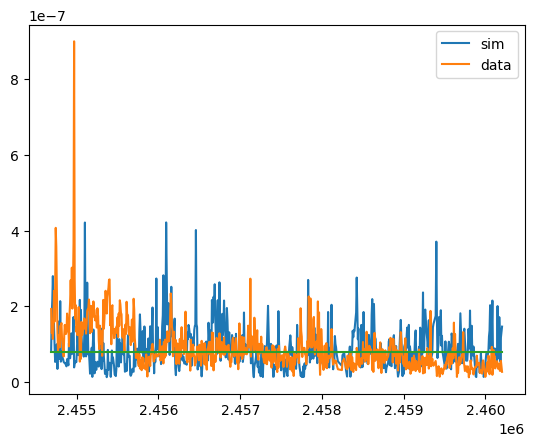

In [4]:
plt.plot(df2["Time"],df2["Flux"],label='sim')
plt.plot(date,Flux,label='data')

plt.plot([np.min(date),np.max(date)],[7.92e-08,7.92e-08])
plt.legend()

In [5]:
def rm_data(date,Flux, limit,siga):
    new_date=[]
    new_Flux=[]
    for i in range(len(Flux)):
        if Flux[i] > np.random.normal(limit,siga):
            new_date.append(date[i])
            new_Flux.append(Flux[i])
    new_date=np.array(new_date)
    new_Flux=np.array(new_Flux)
    return new_date, new_Flux

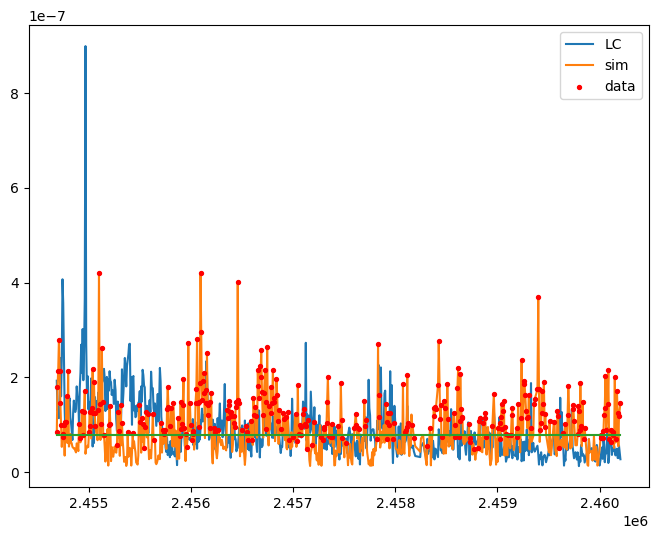

In [6]:
limit=7.92e-08
sigma=2e-08
new_date, new_Flux=rm_data(df2["Time"],df2["Flux"], limit,sigma)


plt.figure(figsize=(8,6))
plt.plot(date,Flux,label='LC',zorder=0)
plt.plot(df2["Time"],df2["Flux"],label='sim',zorder=1)

plt.scatter(new_date, new_Flux,c='r',label='data',zorder=2,s=8)

plt.plot([np.min(date),np.max(date)],[limit,limit])
plt.legend()

In [7]:

def mcmc(date,Flux,deltat,bins):
    n=len(Flux)
    flux_mean=np.mean(Flux)
    DFJ=np.zeros(n-1)
    DFJ_PS=np.zeros(n-1)
    f=np.zeros(n-1)
    time=date-date[0]
    for i in range(n-1):
        f[i]=i/n/deltat
        
        DFJ[i]=(np.sum((Flux-flux_mean)*np.cos((2*np.pi*f[i]*time))))**2+(np.sum((Flux-flux_mean)*np.sin((2*np.pi*f[i]*time)))**2)
        
        #sig=np.mean(error**2)
        #Pnoise=(2*deltat*sig)/flux_mean**2
        #DFJ_PS[i]=DFJ[i]-Pnoise
        
    a,b=np.histogram((f[1:]), bins=bins, range=None, density=None, weights=None)
    b=(b[1:]+(b[0]-b[1])/2)

    c=1
    d=1
    errormean=np.zeros(bins)
    errorbar=np.zeros(bins)
    for i in range(bins):
        d += a[i]
        errormean[i]=(np.mean(np.log10(DFJ[c:d])))
        errorbar[i]=np.std((np.log10(DFJ[c:d])))
        c += a[i]

    C = np.diag(errorbar * errorbar)
    C_inv = np.linalg.inv(C)

    def PL(theta,x):
        alpha1,b1=theta
        return alpha1*x+b1
        
    def log_likelihood_PL(theta):
        alpha1,b1=theta
        delta_T=errormean-(alpha1*np.log10(b)+b1)
        delta=delta_T.reshape(len(delta_T),1)
        chi2=delta_T@C_inv@delta
        return -0.5*chi2


    def PLc(theta,x):
        alpha1,alpha2,b1=theta
        return alpha1*x**2+alpha2*x+b1
        
    def log_likelihood_PLc(theta):
        delta_T=errormean-(PLc(theta,np.log10(b)))
        delta=delta_T.reshape(len(delta_T),1)
        chi2=delta_T@C_inv@delta
        
        return -0.5*chi2
    

    
    def BPL(theta,x):
        alpha1,alpha2,break1,b1=theta
        
        if x<break1:
            return alpha1*x+b1
        
        else:
            return alpha2*x+(alpha1-alpha2)*break1+b1
    
    def log_likelihood_BPL(theta):

        delta_T=np.array([errormean[i]-(BPL(theta,np.log10(b)[i])) for i in range(len(np.log10(b)))])
        delta=delta_T.reshape(len(delta_T),1)
        chi2=delta_T@C_inv@delta
        
        return -0.5*chi2



    nll = lambda *args: -log_likelihood_PL(*args)
    initial = np.array([-1,-13.5])
    soln_PL = minimize(nll, initial,)
    print("PL=",-2*log_likelihood_PL(soln_PL.x))


    nll = lambda *args: -log_likelihood_PLc(*args)
    initial = np.array([-1,-2,-13.5])
    soln_PLc = minimize(nll, initial)
    print("CPL=",-2*log_likelihood_PLc(soln_PLc.x))

    nll = lambda *args: -log_likelihood_BPL(*args)
    initial = np.array([-0.5,-0.5,-2.5,-1])
    soln_BPL = minimize(nll, initial,bounds=[(-np.inf,np.inf),(-np.inf,np.inf),(-3,0),(-np.inf,np.inf)])

    print("BPL=",-2*log_likelihood_BPL(soln_BPL.x))


    '''

    nwalkers=30
    nsteps=1000

    pos=soln_PL.x+np.random.randn(nwalkers, 2)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_PL)
    sampler.run_mcmc(pos, nsteps)

    samples = sampler.get_chain()

    PL_samples = sampler.get_chain(discard=300, thin=15, flat=True)



    nwalkers=300
    nsteps=1000

    pos=soln_PLc.x+np.random.randn(nwalkers, 3)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_PLc)
    sampler.run_mcmc(pos, nsteps)

    samples = sampler.get_chain()

    PLc_samples = sampler.get_chain(discard=300, thin=15, flat=True)


    nwalkers=300
    nsteps=1000

    pos=soln_BPL.x+np.random.randn(nwalkers, 4)
    nwalkers, ndim = pos.shape

    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_likelihood_BPL)
    sampler.run_mcmc(pos, nsteps)

    samples = sampler.get_chain()

    BPL_samples = sampler.get_chain(discard=300, thin=15, flat=True)


    
    c = ChainConsumer()
    c.add_chain(PL_samples, parameters=['$alpha1$', '$b1$'])

    fig = c.plotter.plot(figsize="column")
    fig.set_size_inches(fig.get_size_inches()-1)

    c = ChainConsumer()
    c.add_chain(PLc_samples, parameters=['$alpha1$', '$alpha2$','$b1$'])
    fig = c.plotter.plot(figsize="column")
    fig.set_size_inches(fig.get_size_inches()-1)
    plt.show()

    c = ChainConsumer()
    c.add_chain(BPL_samples, parameters=['$alpha1$', '$alpha2$','$b1$'])
    fig = c.plotter.plot(figsize="column")
    fig.set_size_inches(fig.get_size_inches()-1)
    plt.show()

    '''
    plt.title("$deltat$={:0d}".format(deltat)) 

    plt.scatter(np.log10(f[1:]),np.log10(DFJ[1:]))
    plt.errorbar(np.log10(b),errormean,yerr=errorbar,color='r',linestyle='None', fmt='ob')
    
    plt.plot(np.log10(f[1:]),PL(soln_PL.x,np.log10(f[1:])),c='k',label='alpha1={:f}'.format(soln_PL.x[0]))
    plt.plot(np.log10(f[1:]),PLc(soln_PLc.x,np.log10(f[1:])),c='b',label='alpha1={:f}, alpha2={:0f}'.format(soln_PLc.x[0],soln_PLc.x[1]))

    BPL_PSD=np.array([(BPL(soln_BPL.x,np.log10(f[1:])[i])) for i in range(len(np.log10(f[1:])))])

    plt.plot(np.log10(f[1:]),BPL_PSD,c='g',label='alpha1={:f}, alpha2={:0f}, break1={:0f}'.format(soln_BPL.x[0],soln_BPL.x[1],soln_BPL.x[2]))
    plt.legend()
    plt.show()

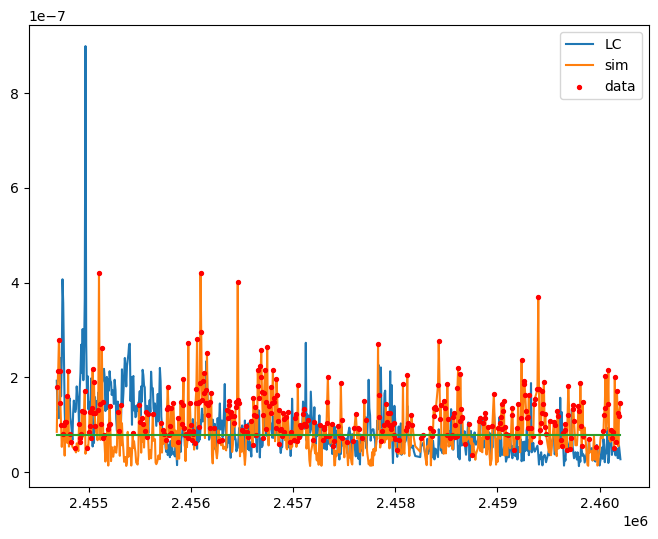

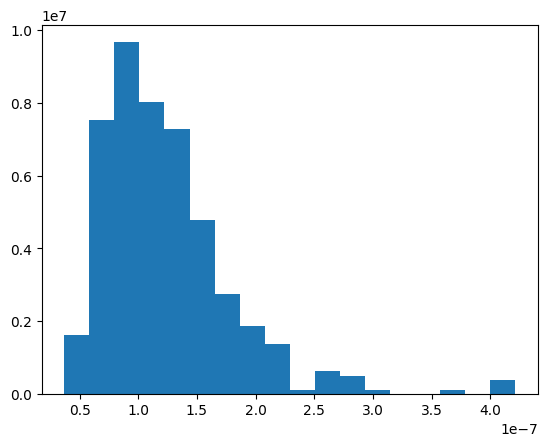

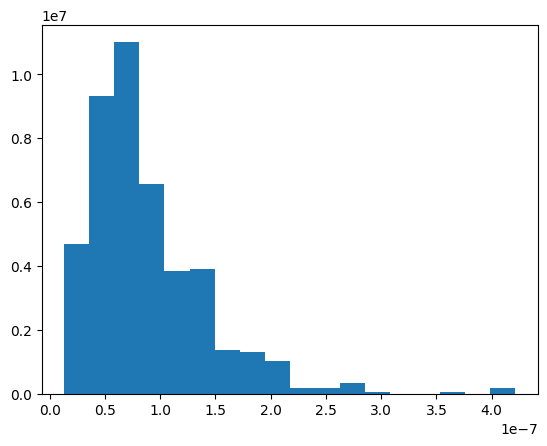

PL= [22.21402476]
CPL= [22.01596894]
BPL= [35.10754063]


/var/folders/s8/2t07wvg55y15czcp4d9jfs0r0000gn/T/ipykernel_21760/1515376619.py:163: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ob" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(np.log10(b),errormean,yerr=errorbar,color='r',linestyle='None', fmt='ob')


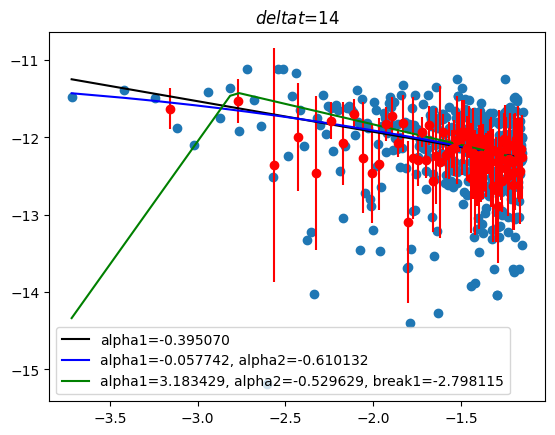

PL= [12.44684547]
CPL= [12.4431758]
BPL= [13.9785338]


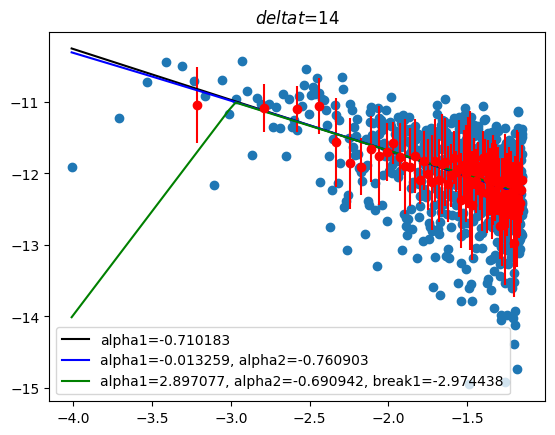

In [8]:
np.random.seed(0)
df2= pd.read_csv("lightcurve.dat", sep="\s+")

limit=7.92e-08
sigma=2e-08
new_date, new_Flux=rm_data(df2["Time"],df2["Flux"], limit,sigma)

data = {'new_date' : new_date,'new_Flux':new_Flux, 'error': np.zeros(len(new_Flux)) }
df = pd.DataFrame(data)

df.to_csv('new_data.dat',sep = '\t',index = False)

plt.figure(figsize=(8,6))
plt.plot(date,Flux,label='LC',zorder=0)
plt.plot(df2["Time"],df2["Flux"],label='sim',zorder=1)

plt.scatter(new_date, new_Flux,c='r',label='data',zorder=2,s=8)

plt.plot([np.min(date),np.max(date)],[limit,limit])
plt.legend()
plt.show()

plt.hist(new_Flux,bins=18,density=True )
plt.show()

plt.hist(df2["Flux"],bins=18,density=True )
plt.show()

deltat=14
bins=70
mcmc(new_date, new_Flux,deltat,bins)

deltat=14
bins=70
mcmc(df2["Time"],df2["Flux"],deltat,bins)

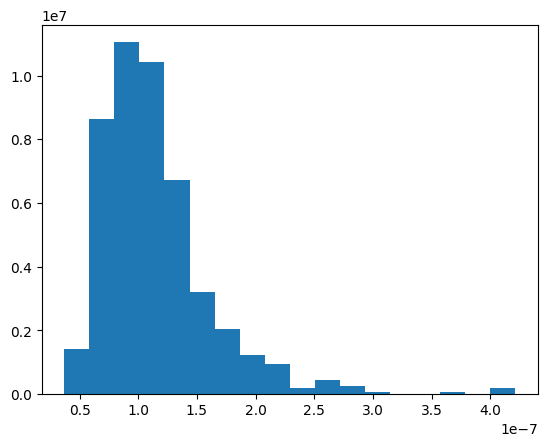

PL= [12.58278098]
CPL= [11.2594569]
BPL= [10.56064377]


/var/folders/s8/2t07wvg55y15czcp4d9jfs0r0000gn/T/ipykernel_21760/1515376619.py:163: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ob" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(np.log10(b),errormean,yerr=errorbar,color='r',linestyle='None', fmt='ob')


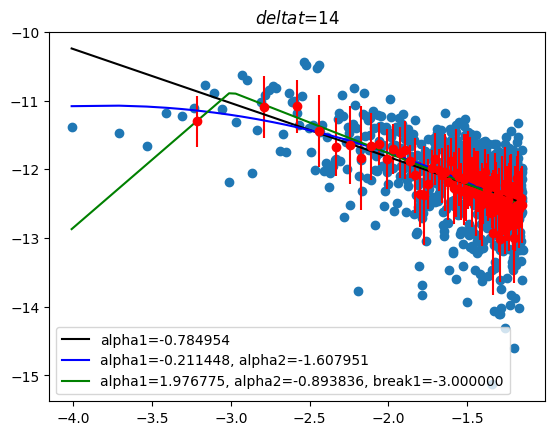

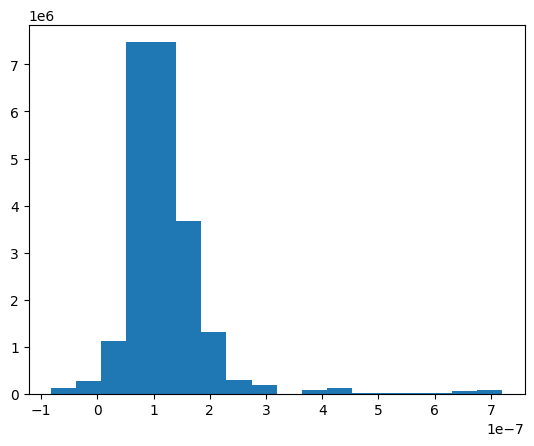

PL= [21.56025168]
CPL= [17.32353536]
BPL= [13.16953101]


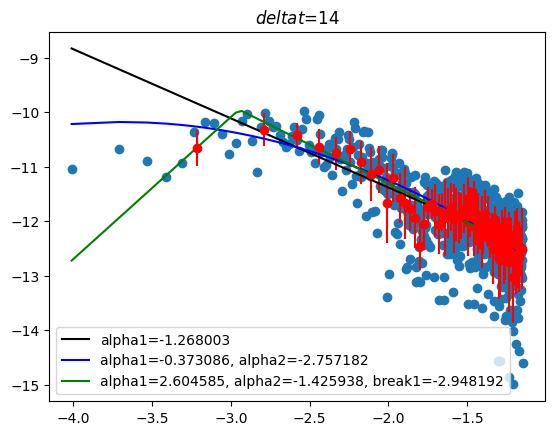

In [9]:
inter_Flux=np.interp(df2["Time"], new_date, new_Flux)


plt.hist(inter_Flux,bins=18,density=True )
plt.show()


deltat=14
bins=70
mcmc(df2["Time"],inter_Flux,deltat,bins)


from scipy.interpolate import CubicSpline
cs = CubicSpline(new_date, new_Flux)
inter_Flux2=cs(df2["Time"])


plt.hist(inter_Flux2,bins=18,density=True )
plt.show()


deltat=14
bins=70
mcmc(df2["Time"],inter_Flux2,deltat,bins)


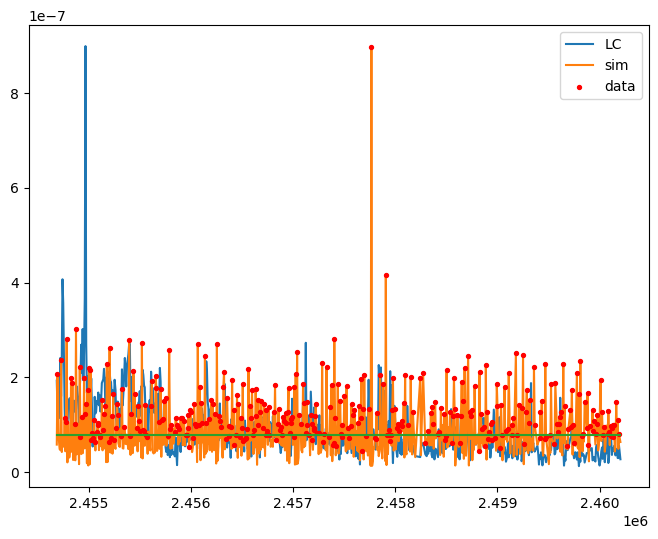

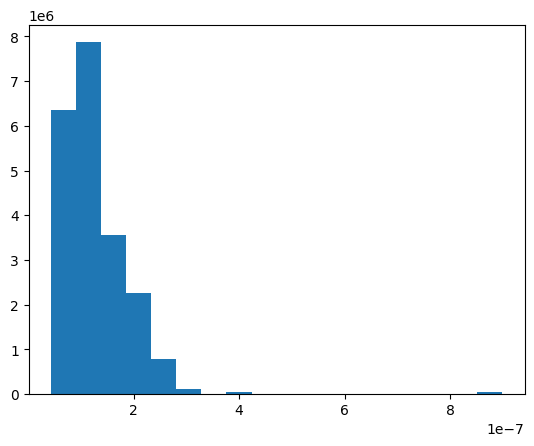

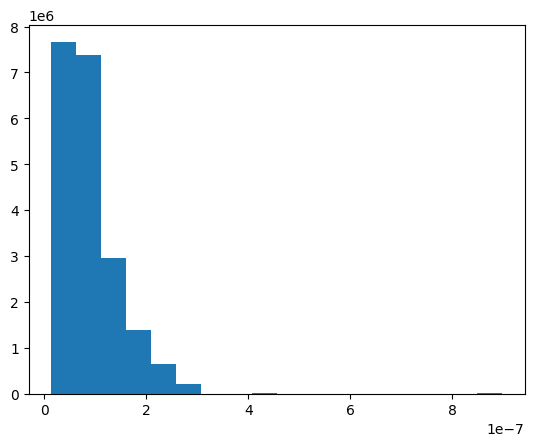

PL= [26.50021194]
CPL= [25.79048957]
BPL= [26.25378272]


/var/folders/s8/2t07wvg55y15czcp4d9jfs0r0000gn/T/ipykernel_21760/1515376619.py:163: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ob" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(np.log10(b),errormean,yerr=errorbar,color='r',linestyle='None', fmt='ob')


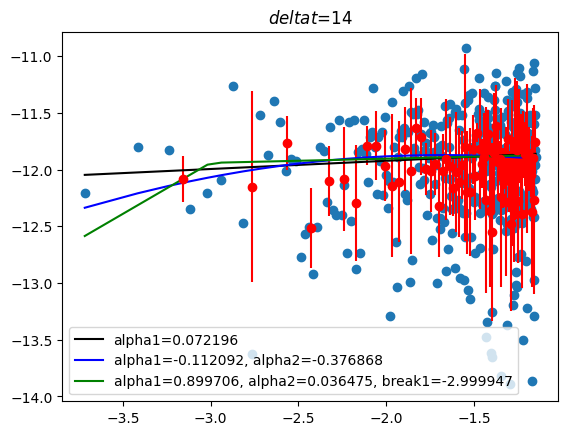

PL= [13.96563256]
CPL= [13.39001604]
BPL= [13.77881248]


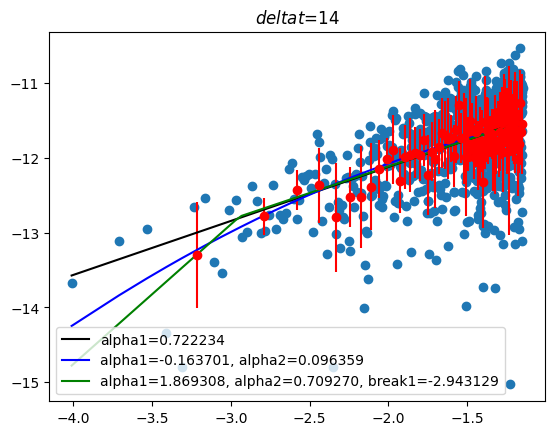

In [10]:
np.random.seed(0)
df2= pd.read_csv("PL.dat", sep="\s+")

limit=7.92e-08
sigma=2e-08
new_date, new_Flux=rm_data(df2["Time"],df2["Flux"], limit,sigma)

data = {'new_date' : new_date,'new_Flux':new_Flux, 'error': np.zeros(len(new_Flux)) }
df = pd.DataFrame(data)

df.to_csv('new_data.dat',sep = '\t',index = False)

plt.figure(figsize=(8,6))
plt.plot(date,Flux,label='LC',zorder=0)
plt.plot(df2["Time"],df2["Flux"],label='sim',zorder=1)

plt.scatter(new_date, new_Flux,c='r',label='data',zorder=2,s=8)

plt.plot([np.min(date),np.max(date)],[limit,limit])
plt.legend()
plt.show()

plt.hist(new_Flux,bins=18,density=True )
plt.show()

plt.hist(df2["Flux"],bins=18,density=True )
plt.show()

deltat=14
bins=70
mcmc(new_date, new_Flux,deltat,bins)

deltat=14
bins=70
mcmc(df2["Time"],df2["Flux"],deltat,bins)

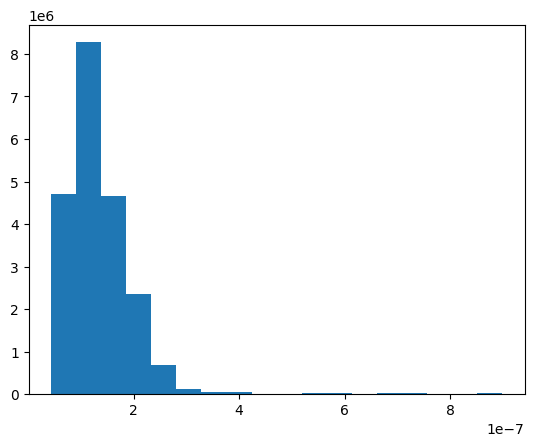

PL= [46.85572123]
CPL= [25.76786656]
BPL= [22.00158645]


/var/folders/s8/2t07wvg55y15czcp4d9jfs0r0000gn/T/ipykernel_21760/1515376619.py:163: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ob" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(np.log10(b),errormean,yerr=errorbar,color='r',linestyle='None', fmt='ob')


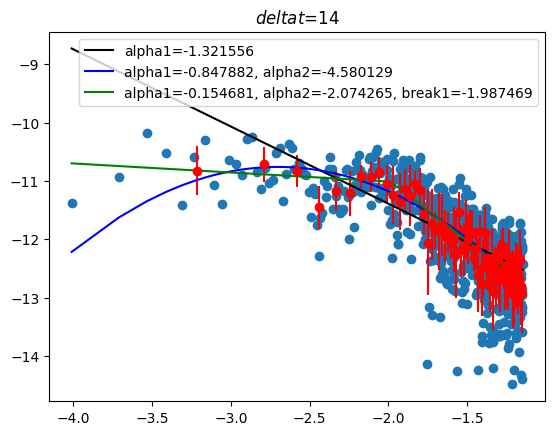

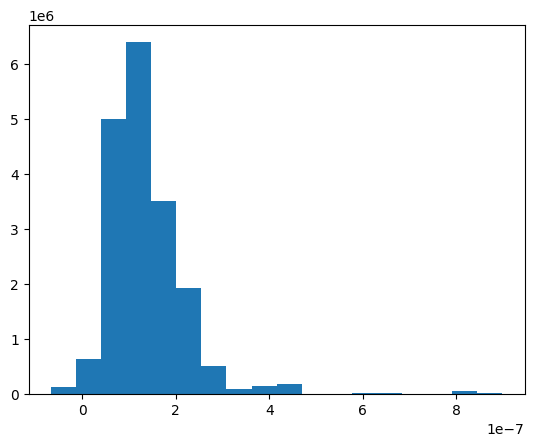

PL= [54.04631269]
CPL= [23.29071131]
BPL= [18.72443128]


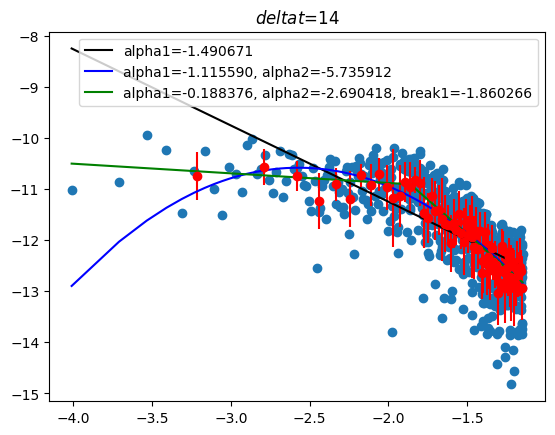

In [11]:
inter_Flux=np.interp(df2["Time"], new_date, new_Flux)


plt.hist(inter_Flux,bins=18,density=True )
plt.show()


deltat=14
bins=70
mcmc(df2["Time"],inter_Flux,deltat,bins)


from scipy.interpolate import CubicSpline
cs = CubicSpline(new_date, new_Flux)
inter_Flux2=cs(df2["Time"])


plt.hist(inter_Flux2,bins=18,density=True )
plt.show()


deltat=14
bins=70
mcmc(df2["Time"],inter_Flux2,deltat,bins)


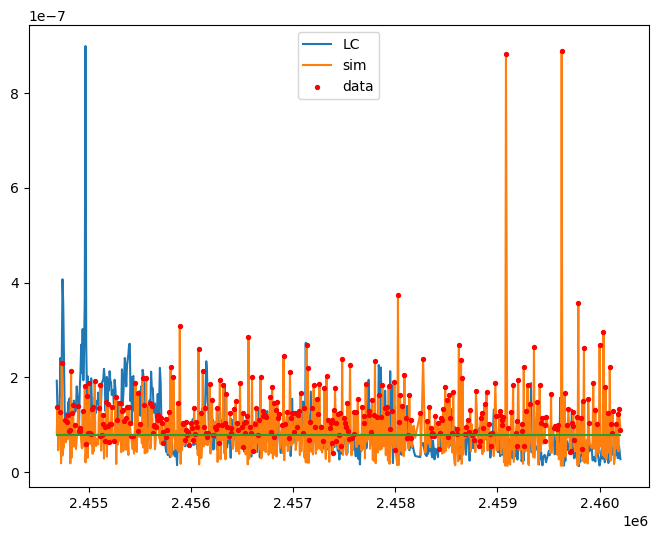

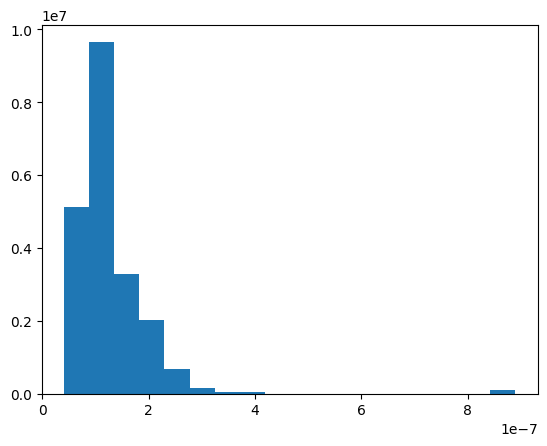

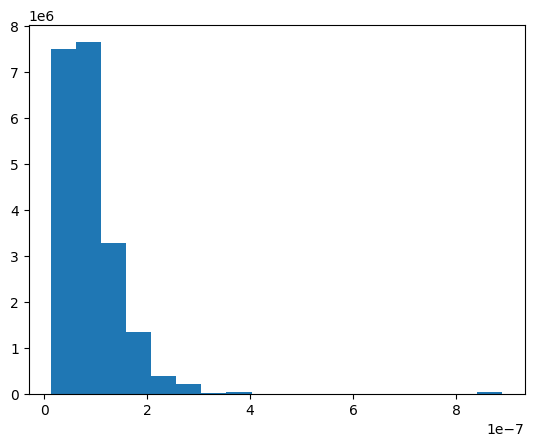

PL= [24.36249074]
CPL= [23.07538589]
BPL= [23.69023911]


/var/folders/s8/2t07wvg55y15czcp4d9jfs0r0000gn/T/ipykernel_21760/1515376619.py:163: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ob" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(np.log10(b),errormean,yerr=errorbar,color='r',linestyle='None', fmt='ob')


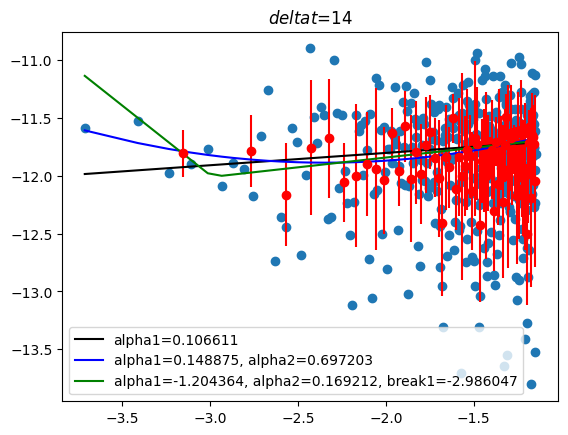

PL= [20.8132145]
CPL= [20.80899135]
BPL= [20.4252332]


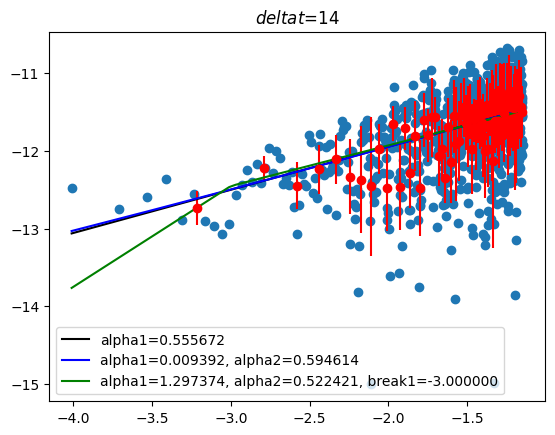

In [12]:
np.random.seed(0)
df2= pd.read_csv("BPL.dat", sep="\s+")

limit=7.92e-08
sigma=2e-08
new_date, new_Flux=rm_data(df2["Time"],df2["Flux"], limit,sigma)

data = {'new_date' : new_date,'new_Flux':new_Flux, 'error': np.zeros(len(new_Flux)) }
df = pd.DataFrame(data)

df.to_csv('new_data.dat',sep = '\t',index = False)

plt.figure(figsize=(8,6))
plt.plot(date,Flux,label='LC',zorder=0)
plt.plot(df2["Time"],df2["Flux"],label='sim',zorder=1)

plt.scatter(new_date, new_Flux,c='r',label='data',zorder=2,s=8)

plt.plot([np.min(date),np.max(date)],[limit,limit])
plt.legend()
plt.show()

plt.hist(new_Flux,bins=18,density=True )
plt.show()

plt.hist(df2["Flux"],bins=18,density=True )
plt.show()

deltat=14
bins=70
mcmc(new_date, new_Flux,deltat,bins)

deltat=14
bins=70
mcmc(df2["Time"],df2["Flux"],deltat,bins)

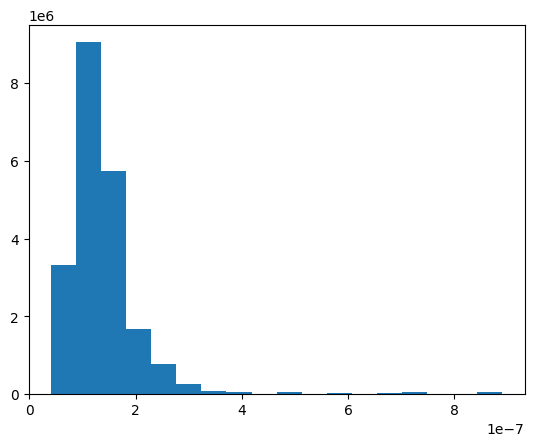

PL= [41.43909952]
CPL= [34.47986356]
BPL= [29.13189459]


/var/folders/s8/2t07wvg55y15czcp4d9jfs0r0000gn/T/ipykernel_21760/1515376619.py:163: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ob" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(np.log10(b),errormean,yerr=errorbar,color='r',linestyle='None', fmt='ob')


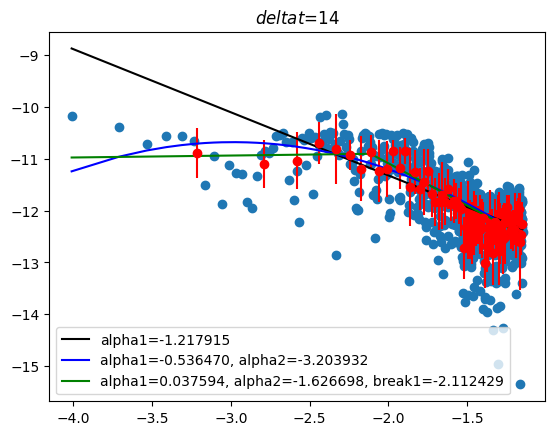

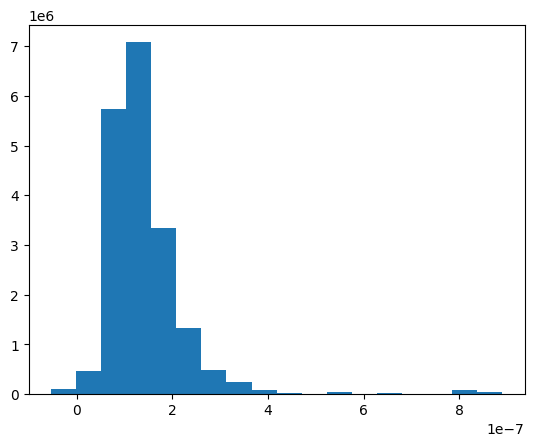

PL= [34.47472259]
CPL= [26.51036461]
BPL= [22.03296242]


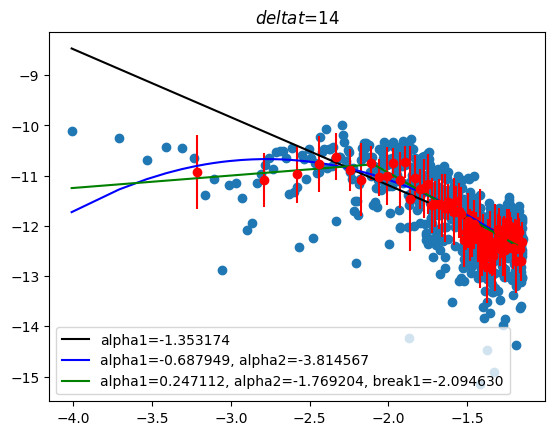

In [13]:
inter_Flux=np.interp(df2["Time"], new_date, new_Flux)


plt.hist(inter_Flux,bins=18,density=True )
plt.show()


deltat=14
bins=70
mcmc(df2["Time"],inter_Flux,deltat,bins)


from scipy.interpolate import CubicSpline
cs = CubicSpline(new_date, new_Flux)
inter_Flux2=cs(df2["Time"])


plt.hist(inter_Flux2,bins=18,density=True )
plt.show()


deltat=14
bins=70
mcmc(df2["Time"],inter_Flux2,deltat,bins)


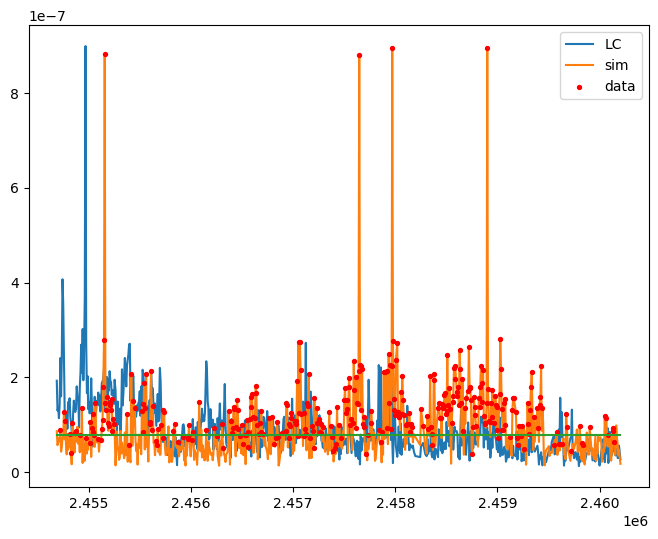

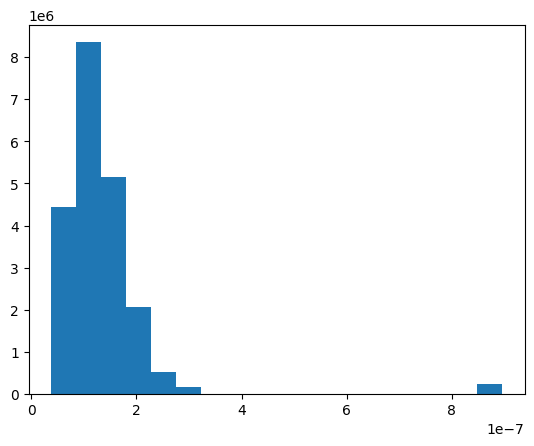

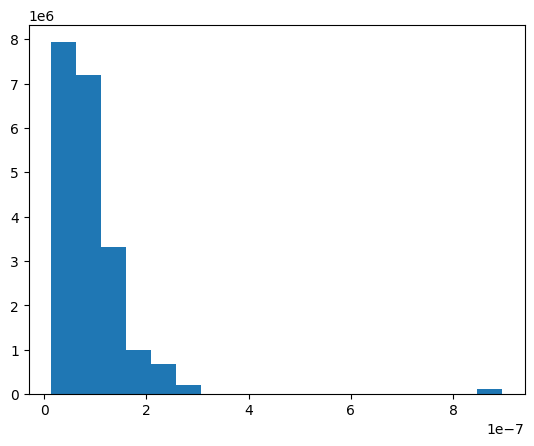

PL= [26.20921303]
CPL= [24.37699607]
BPL= [26.05452732]


/var/folders/s8/2t07wvg55y15czcp4d9jfs0r0000gn/T/ipykernel_21760/1515376619.py:163: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ob" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(np.log10(b),errormean,yerr=errorbar,color='r',linestyle='None', fmt='ob')


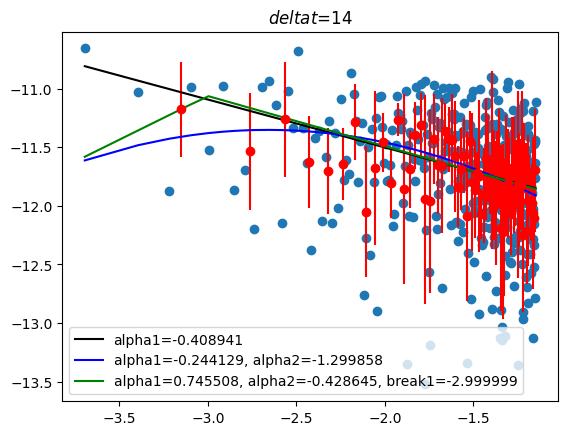

PL= [15.81883571]
CPL= [15.8095862]
BPL= [15.74498953]


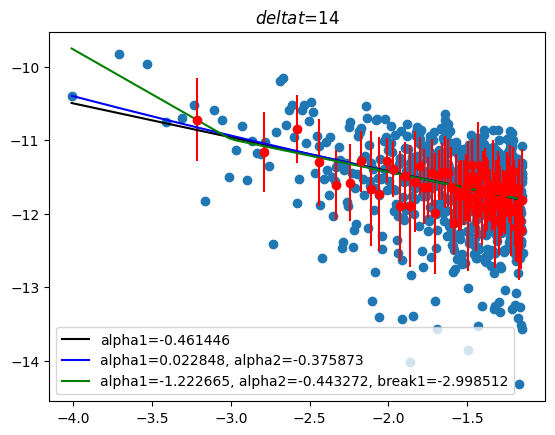

In [14]:
np.random.seed(0)
df2= pd.read_csv("CPL.dat", sep="\s+")

limit=7.92e-08
sigma=2e-08
new_date, new_Flux=rm_data(df2["Time"],df2["Flux"], limit,sigma)

data = {'new_date' : new_date,'new_Flux':new_Flux, 'error': np.zeros(len(new_Flux)) }
df = pd.DataFrame(data)

df.to_csv('new_data.dat',sep = '\t',index = False)

plt.figure(figsize=(8,6))
plt.plot(date,Flux,label='LC',zorder=0)
plt.plot(df2["Time"],df2["Flux"],label='sim',zorder=1)

plt.scatter(new_date, new_Flux,c='r',label='data',zorder=2,s=8)

plt.plot([np.min(date),np.max(date)],[limit,limit])
plt.legend()
plt.show()

plt.hist(new_Flux,bins=18,density=True )
plt.show()

plt.hist(df2["Flux"],bins=18,density=True )
plt.show()

deltat=14
bins=70
mcmc(new_date, new_Flux,deltat,bins)

deltat=14
bins=70
mcmc(df2["Time"],df2["Flux"],deltat,bins)

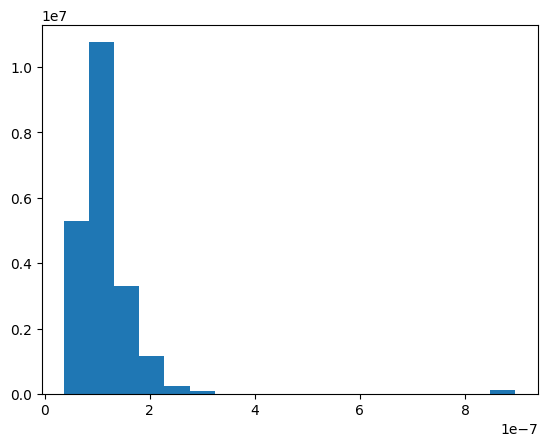

PL= [10.83743616]
CPL= [10.76252814]
BPL= [10.81931062]


/var/folders/s8/2t07wvg55y15czcp4d9jfs0r0000gn/T/ipykernel_21760/1515376619.py:163: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ob" (-> color='b'). The keyword argument will take precedence.
  plt.errorbar(np.log10(b),errormean,yerr=errorbar,color='r',linestyle='None', fmt='ob')


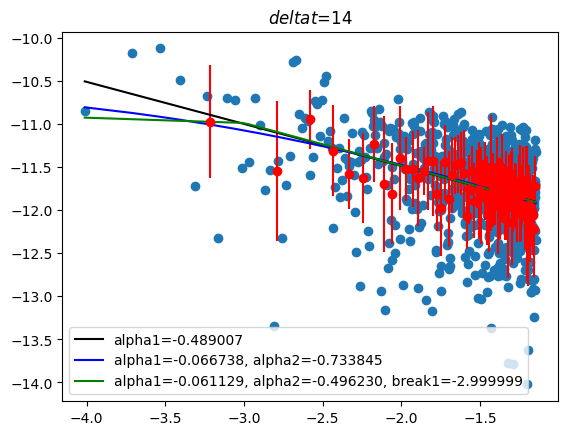

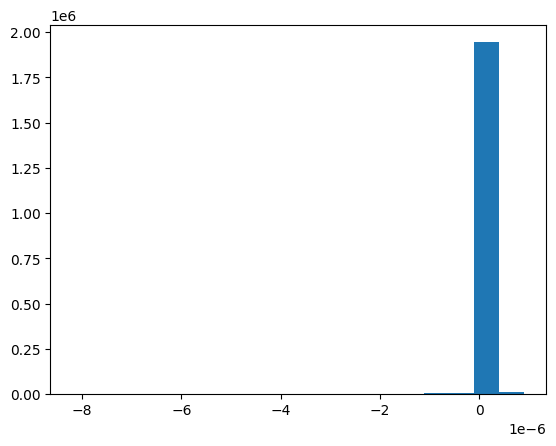

PL= [325.09448025]
CPL= [259.62500609]
BPL= [324.66973837]


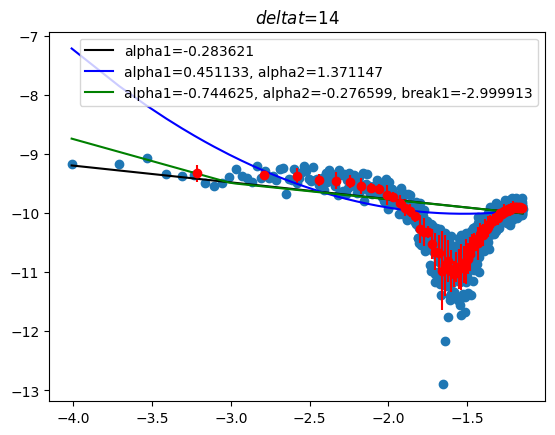

ImportError: cannot import name 'Tester' from 'numpy.testing' (/opt/homebrew/anaconda3/envs/camb/lib/python3.10/site-packages/numpy/testing/__init__.py)

In [15]:
inter_Flux=np.interp(df2["Time"], new_date, new_Flux)


plt.hist(inter_Flux,bins=18,density=True )
plt.show()


deltat=14
bins=70
mcmc(df2["Time"],inter_Flux,deltat,bins)


from scipy.interpolate import CubicSpline
cs = CubicSpline(new_date, new_Flux)
inter_Flux2=cs(df2["Time"])


plt.hist(inter_Flux2,bins=18,density=True )
plt.show()


deltat=14
bins=70
mcmc(df2["Time"],inter_Flux2,deltat,bins)



In [19]:
!pip install --upgrade numpy

In [20]:
from numpy.testing import Tester

ImportError: cannot import name 'Tester' from 'numpy.testing' (/opt/homebrew/anaconda3/envs/camb/lib/python3.10/site-packages/numpy/testing/__init__.py)